In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

champions = pd.read_csv('data/championsdata.csv')
subchampions = pd.read_csv('data/runnerupsdata.csv')
total = pd.concat([champions, subchampions], ignore_index=True)
total

,Year,Team,Game,Win,Home,MP,FG,FGA,FGP,TP,...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1980,Lakers,1,1,1,240,48,89,0.539,0,...,0.867,12,31,43,30,5,9,17,24,109
1,1980,Lakers,2,0,1,240,48,95,0.505,0,...,0.667,15,37,52,32,12,7,26,27,104
2,1980,Lakers,3,1,0,240,44,92,0.478,0,...,0.767,22,34,56,20,5,5,20,25,111
3,1980,Lakers,4,0,0,240,44,93,0.473,0,...,0.737,18,31,49,23,12,6,19,22,102
4,1980,Lakers,5,1,1,240,41,91,0.451,0,...,0.788,19,37,56,28,7,6,21,27,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,2017,Cavaliers,5,0,0,240,47,88,0.534,11,...,0.652,12,28,40,22,6,5,14,22,120
436,2018,Cavaliers,1,0,0,265,44,99,0.444,10,...,0.727,19,34,53,18,5,3,11,18,114
437,2018,Cavaliers,2,0,0,240,37,90,0.411,9,...,0.769,16,26,42,25,9,4,10,15,103
438,2018,Cavaliers,3,0,1,240,40,92,0.435,9,...,0.765,15,32,47,20,6,4,13,18,102


## **1. DATA MINING:**

En esta sección se analiza el conjunto de datos de las finales de la NBA (1980-2018) con el objetivo de identificar patrones y relaciones entre las variables. Se explorarán los tipos de atributos, su distribución y su relación con el resultado del partido (`Win`) para preparar el dataset para la construcción de modelos predictivos.

---

### **· Análisis de variables**

A continuación se expone los tipos de atributos del dataset de estadísticas de las finales de la NBA (1980-2018), clasificando las variables según su naturaleza: categóricas, discretas y continuas.

#### 🟦 **Variables Categóricas:** <small> Variables que representan categorías o grupos, no números con valor matemático.</small>

##### **Categóricas nominales:** <small> Categorías sin orden específico. </small>

<small>

| Variable | Explicación       |
| -------- | ----------------- |
| `Team` | Nombre del equipo |

</small>

##### **Categóricas binarias:** <small> Categorías con solo dos posibles valores.</small>

<small>

| Variable | Explicación              |
| -------- | ------------------------ |
| `Win`  | 1 = ganó, 0 = perdió     |
| `Home` | 1 = local, 0 = visitante |

</small>



#### 🟩 **Variables Numéricas Discretas:** <small> Valores numéricos contables, generalmente enteros. </small>

<small>

| Variable | Explicación                   |
| -------- | ----------------------------- |
| `Year`   | Año de la final               |
| `Game`   | Número de partido en la serie |
| `MP`     | Minutos jugados               |
| `FG`     | Tiros encestados              |
| `FGA`    | Tiros intentados              |
| `TP`     | Triples encestados            |
| `TPA`    | Triples intentados            |
| `FT`     | Libres encestados             |
| `FTA`    | Libres intentados             |
| `PTS`    | Puntos                        |
| `ORB`    | Rebotes ofensivos             |
| `DRB`    | Rebotes defensivos            |
| `TRB`    | Rebotes totales               |
| `AST`    | Asistencias                   |
| `STL`    | Robos                         |
| `BLK`    | Tapones                       |
| `TOV`    | Pérdidas                      |
| `PF`     | Faltas personales             |

</small>


#### 🟧 **Variables Numéricas Continuas:** <small> Valores numéricos que pueden tomar cualquier valor dentro de un rango (en este caso porcentages).</small>

<small>

| Variable | Explicación              |
| -------- | ------------------------ |
| `FGP`    | % acierto tiros de campo |
| `TPP`    | % acierto triples        |
| `FTP`    | % acierto tiros libres   |

</small>

<br>

---

### **· Feature Engineering**

##### **Variable Objetivo (Target):** `Win` (Binaria: 0 o 1).
##### **Definición del Target y Limpieza de Variables Categóricas/Contextuales**
Para garantizar la robustez del modelo, eliminamos variables que no reflejan rendimiento deportivo o que introducen ruido.

Primero vamos a eliminar **Identificadores y Metadatos (`Team`, `Year`, `Game`)**. Estas variables aportan contexto histórico pero no métricas de juego. Queremos que el modelo aprenda a identificar **patrones de rendimiento**, por ejemplo, quien recupera más rebotes, gana. No se trata de memorizar **identidades**, si tu equipo son los Bulls de los 90, probablemente gane. Eliminar el nombre del equipo evita el sesgo de identidad y mejora la capacidad de generalización del modelo a futuros equipos.

Por otro lado, la variable **Minutes Played (`MP`)** presenta una **varianza casi nula** y carece de poder discriminante. En un partido de baloncesto, tanto el ganador como el perdedor juegan exactamente la misma cantidad de minutos, 240, o más si hay prórroga. Por tanto, `MP` no sirve para diferenciar una victoria de una derrota.

##### **Eliminación de Variables Númericas**
En cuanto a las variables numéricas, se ha procedido a descartar aquellas métricas derivadas que representan ratios de eficiencia (`FGP`, `TPP`, `FTP`). Esta decisión se basa en dos factores.

Primero, queremos **evitar la Multicolinealidad**. Dado que el dataset ya incluye los valores absolutos de intentos (Attempts) y aciertos (Makes), la variable de porcentaje es una combinación lineal directa de ambas ($Porcentaje = Aciertos / Intentos$). Mantener las tres variables no aporta información nueva.

Segundo, para la predicción de una victoria, **el volumen de intentos (valores absolutos) es un predictor más robusto que la eficiencia relativa de dichos intentos**. Por ejemplo: Un jugador puede tener un 100% de efectividad (FGP = 1.0) habiendo encestado solo 1 de 1 tiro. Mientras, otro jugador con un 50% de efectividad (FGP = 0.5) ha encestando 10 de 20 tiros. Aunque el primero es más "eficiente" en el ratio, el segundo ha generado 20 puntos frente a los 2 generados por el primero. El modelo necesita conocer la magnitud de la los aciertos absolutos para determinar su peso en el resultado final, algo que el porcentaje por sí solo enmascara al normalizar el dato.

Asimismo, se ha prescindido de la variable `TRB` (Rebotes Totales). Al tratarse de una suma algebraica de los rebotes ofensivos y defensivos, su inclusión resulta redundante. Además, desde el punto de vista táctico, consideramos que el rebote ofensivo y el defensivo juegan roles distintos en la dinámica de partido, por lo que es preferible mantener su granularidad por separado.

---

In [2]:
# 1. Preparar las variables (X) y el objetivo (y)
# ---------------------------------------------------------
X = total.drop(['Win', 'Team', 'Year', 'Game','MP','FGP','TPP','FTP','TRB'], axis=1)
Y = total['Win']

print("Shape del dataset final:")
print(f"X: {X.shape}  →  {X.shape[1]} variables predictoras")
print(f"y: {Y.shape}\n")

print("Variables utilizadas como predictores:")
print(X.columns.tolist())
print("\nPrimeras 5 filas de X:")
display(X.head())

print("\nDistribución del target (Win):")
print(Y.value_counts(normalize=True).round(3))


Shape del dataset final:
X: (440, 15)  →  15 variables predictoras
y: (440,)

Variables utilizadas como predictores:
['Home', 'FG', 'FGA', 'TP', 'TPA', 'FT', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

Primeras 5 filas de X:


,Home,FG,FGA,TP,TPA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
0,1,48,89,0,0,13,15,12,31,30,5,9,17,24,109
1,1,48,95,0,1,8,12,15,37,32,12,7,26,27,104
2,0,44,92,0,1,23,30,22,34,20,5,5,20,25,111
3,0,44,93,0,0,14,19,18,31,23,12,6,19,22,102
4,1,41,91,0,0,26,33,19,37,28,7,6,21,27,108



Distribución del target (Win):
Win
0    0.502
1    0.498
Name: proportion, dtype: float64


### **· Análisis de correlaciones**

En este análisis se busca explorar la relación entre diversas variables predictoras y el resultado de interés, representado por la variable objetivo Win. Para ello, se calcula la matriz de correlaciones de Pearson, permitiendo cuantificar el grado de asociación lineal entre cada variable y Win. Además de identificar las variables con mayor correlación, positiva o negativa, se generan visualizaciones que facilitan la interpretación: un heatmap que muestra las correlaciones entre todas las variables y un barplot que resalta específicamente la relación de cada predictor con Win. Este enfoque proporciona una primera aproximación para seleccionar variables relevantes y entender cómo influyen en el resultado.


Correlaciones con 'Win' (ordenadas por valor absoluto):
DRB     0.383
PTS     0.380
FG      0.272
AST     0.258
PF      0.228
Home    0.214
FT      0.214
FTA     0.194
TOV     0.165
STL     0.139
BLK     0.137
TP      0.086
TPA     0.077
FGA     0.065
ORB     0.030
Name: Win, dtype: float64


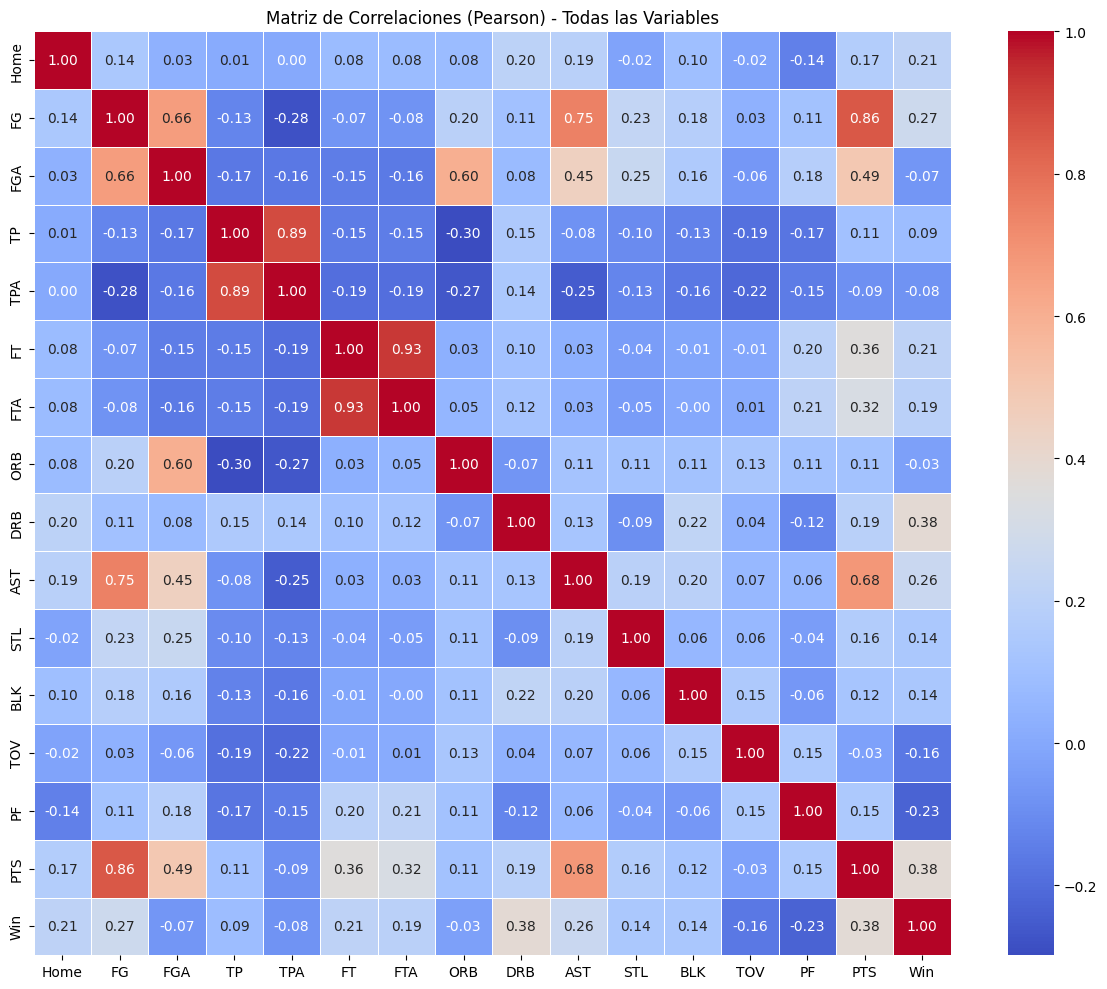

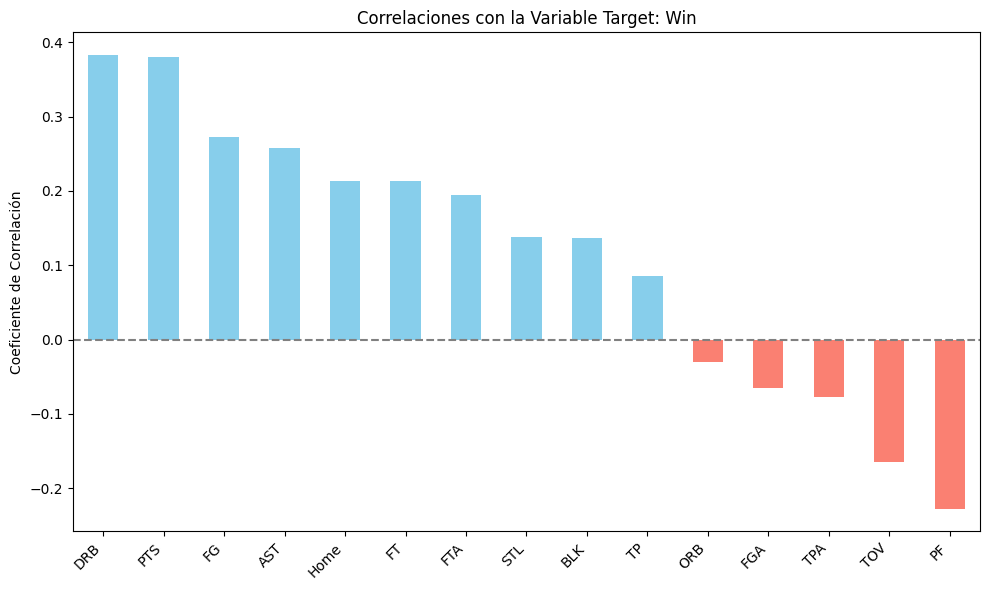

DRB     0.382820
PTS     0.379741
FG      0.271920
AST     0.257825
Home    0.213639
FT      0.213524
FTA     0.194094
STL     0.138613
BLK     0.136877
TP      0.086177
ORB    -0.030435
FGA    -0.065270
TPA    -0.076620
TOV    -0.164824
PF     -0.227693
Name: Win, dtype: float64


In [4]:

# Añadimos temporalmente el target 'Win' al DataFrame para calcular correlaciones
df_corr = pd.concat([X, Y], axis=1)

# Calculamos la matriz de correlación (Pearson por defecto, adecuado para variables numéricas)
corr_matrix = df_corr.corr()

# Filtramos solo la correlación con 'Win' (ordenada de mayor a menor absoluta)
corr_with_win = corr_matrix['Win'].drop('Win').sort_values(ascending=False)
print("\nCorrelaciones con 'Win' (ordenadas por valor absoluto):")
print(corr_with_win.abs().sort_values(ascending=False).round(3))

# Visualización 1: Heatmap de correlaciones entre TODAS las variables (incluyendo Win)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlaciones (Pearson) - Todas las Variables')
plt.tight_layout()
plt.show()

# print(corr_matrix)

# Visualización 2: Barplot de correlaciones SOLO con 'Win' (positivo/negativo)
plt.figure(figsize=(10, 6))
corr_with_win.plot(kind='bar', color=['skyblue' if x > 0 else 'salmon' for x in corr_with_win])
plt.title('Correlaciones con la Variable Target: Win')
plt.ylabel('Coeficiente de Correlación')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(corr_with_win)

#### **Resultados: Correlación entre atributos**

La matriz de correlaciones entre los atributos predictivos muestra relaciones lógicas y esperadas en el contexto de estadísticas de baloncesto, destacando varias asociaciones fuertes:

- **Alta multicolinealidad en métricas de tiro**: `FG` (tiros de campo encestados) presenta una correlación muy elevada con `PTS` (0.86) y `AST` (0.75), lo que refleja que los equipos que encestan más suelen anotar más puntos y generar juego colectivo. De igual modo, `TP` y `TPA` están fuertemente correlacionados (0.89), al igual que `FT` y `FTA` (0.93), indicando que los intentos y aciertos en triples y tiros libres van casi siempre de la mano.

- **Relación entre volumen y rebote ofensivo**: `FGA` (0.60) y `ORB` (rebotes ofensivos) muestran una correlación notable positiva, ya que un mayor número de tiros fallados genera más oportunidades de rebote ofensivo.

- **Asistencias y juego eficiente**: `AST` correlaciona positivamente con `FG` (0.75) y moderadamente con `PTS` (0.68), subrayando que un alto número de asistencias suele acompañar ataques efectivos y bien ejecutados.

- **Correlaciones negativas en triples**: `TP` y `TPA` muestran correlaciones negativas moderadas con `FG` (-0.13 y -0.28 respectivamente) y `ORB` (-0.30 y -0.27), lo que sugiere que los equipos que dependen más de los triples tienden a tener menos tiros de campo cercanos y menos rebotes ofensivos.

En resumen, las correlaciones más fuertes se centran en la lógica interna del baloncesto: los aciertos absolutos (`FG`, `TP`, `FT`) están altamente ligados a sus respectivos intentos y a los puntos totales, mientras que el volumen de tiros y los rebotes ofensivos van unidos por la dinámica de fallos y segundas oportunidades. Estas relaciones confirman la coherencia del dataset y advierten posibles problemas de multicolinealidad en modelos lineales, pero resultan útiles para modelos basados en árboles.

#### **Resultados: Correlación de atributos con la variable a predecir**

La matriz de correlaciones de Pearson con la variable objetivo `Win` revela cuáles son los factores estadísticos más asociados al éxito. A continuación se destacan los patrones más relevantes:

- **Puntos y eficiencia ofensiva**: `PTS` (0.38) muestra la correlación más alta positiva con la victoria, confirmándose como el factor determinante. Le sigue de cerca `FG` (0.27), indicando que encestar más tiros de campo es un predictor clave, y `AST` (0.26), que refleja la importancia del juego colectivo y los ataques bien construidos.

- **Control defensivo del rebote**: `DRB` (rebotes defensivos) presenta la mayor correlación individual (0.38), destacando que limitar las segundas oportunidades del rival y controlar el propio aro es uno de los aspectos más decisivos en las finales de la NBA.

- **Ventaja de localía y tiros libres**: `Home` (0.21) confirma un efecto moderado pero consistente de jugar en casa. Los tiros libres también aportan señal positiva, con `FT` (0.21) y `FTA` (0.19), sugiriendo que generar y convertir lanzamientos desde la línea (a menudo por atacar el aro o forzar faltas al rival) contribuye a la victoria.

- **Defensa activa**: `STL` (robos, 0.14) y `BLK` (tapones, 0.14) muestran correlaciones positivas moderadas, indicando que una defensa agresiva que genera disrupción tiene un impacto favorable, aunque menor que el control del rebote o la anotación.

- **Factores negativos más relevantes**: `PF` (faltas personales, -0.23) es el predictor negativo más fuerte, ya que cometer muchas faltas envía al rival a la línea de tiros libres y altera el ritmo del partido. Le sigue `TOV` (pérdidas, -0.16), penalizando los errores no forzados que regalan posesiones.

- **Volumen de lanzamientos**: `FGA` (-0.07) y `TPA` (-0.08) presentan correlaciones negativas leves, lo que sugiere que los equipos que más intentan tiros (especialmente triples) suelen ser los que van por detrás en el marcador y fuerzan su juego. Los triples encestados `TP` (0.09) tienen un impacto positivo bajo, mientras que `ORB` (-0.03) apenas influye.

En resumen, las correlaciones más intensas con la victoria se concentran en anotar más puntos (`PTS`, `FG`), controlar el rebote defensivo (`DRB`) y minimizar errores costosos (`PF`, `TOV`), mientras que la ventaja local y una buena defensa aportan beneficios adicionales. Los patrones negativos en volumen de intentos refuerzan que un juego forzado suele ser síntoma de desventaja, destacando la importancia de la eficiencia y el dominio táctico sobre la cantidad bruta de acciones.

#### **Conclusiones:**

El análisis de correlaciones muestra que los factores más determinantes para la victoria (`Win`) son `PTS` y `DRB` (ambos 0.38), seguidos de `FG` (0.27) y `AST` (0.26), destacando la importancia de anotar puntos con eficiencia colectiva y dominar el rebote defensivo. Los principales aspectos negativos son `PF` (-0.23) y `TOV` (-0.16), que penalizan faltas y pérdidas. Se detecta alta multicolinealidad entre variables como `FG`-`PTS` (0.86), `TP`-`TPA` (0.89) y `FT`-`FTA` (0.93), lo que genera redundancia. Por ello, se recomienda eliminar `FTA` (cuyo aporte predictivo es en parte redundante y está mejor capturado por `FT`) y priorizar aciertos absolutos en modelos lineales para evitar inestabilidad. En modelos basados en árboles, aunque toleran mejor la multicolinealidad, simplificar las variables mejora la interpretabilidad sin comprometer el rendimiento. En resumen, el dataset es sólido, pero una selección cuidadosa de features puede optimizar la estabilidad y efectividad de los modelos predictivos.

In [ ]:
X = X.drop(['FTA'], axis=1) 

Probar amb random forest y regressio logistica <br>
estaria be probar dos models amb: <br>
X = total.drop(['Win'], axis=1) (sense drop) <br>
X = total.drop(['Win', 'Team', 'Year', 'Game','MP','FGP','TPP','FTP','TRB'], axis=1) <br>
X = total.drop(['Win', 'Team', 'Year', 'Game','MP','FGP','TPP','FTP','TRB','FTA'], axis=1)

In [10]:
# 2. Dividir en Train y Test
# ---------------------------------------------------------
# test_size=0.2 significa que guardamos el 20% de los datos para el examen final
# random_state=42 sirve para que la división sea siempre igual cada vez que ejecutes (reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)

# Comprobación rápida de tamaños
print(f"Entrenamiento: {X_train.shape} (Filas, Columnas)")
print(f"Test: {X_test.shape} (Filas, Columnas)")

Entrenamiento: (374, 15) (Filas, Columnas)
Test: (66, 15) (Filas, Columnas)


MP   - Minutos jugados -> Cambiar por categoria OVERTIME (1 SI - 0 NO)
Game - Numero de partido de la serie -> INNECESARIO
Year - Año de la serie -> INNECESARIO
Team - Nombre del equipo -> ¿INNECESARIO? Analizar

# 1. La variable a predecir (Target)
Sin duda alguna, la variable objetivo es:

Win (0 o 1).

Es un problema clásico de clasificación binaria: queremos saber qué factores aumentan la probabilidad de que esa variable sea 1.

# 2. Las variables que más influyen (Hipótesis)
Si tuviera que apostar cuáles tendrán una correlación más fuerte con la victoria (excluyendo PTS, que es el resultado directo), diría que son estas cuatro, en este orden:

## 1. FGP (Porcentaje de Tiros de Campo) y TPP (Triples)
Es la métrica de eficiencia más pura. En la NBA, el equipo que tira con mejor porcentaje suele ganar.

Lógica: No importa cuántos tiros intentes (FGA), si no entran, no sumas. Un FGP alto suele ser el indicador #1 de victoria.

## 2. TOV (Pérdidas de Balón - Turnovers)
Esta debería tener una correlación negativa.

Lógica: Cada pérdida es una oportunidad de tiro que tu equipo pierde y (generalmente) una oportunidad fácil de contraataque para el rival. Quien cuida mejor el balón, suele ganar las finales.

## 3. Home (Factor Cancha)
En la NBA, y especialmente en las finales, jugar en casa es una ventaja estadística masiva.

Lógica: El público, el descanso, no viajar y el arbitraje (a veces) influyen. Espero ver una correlación positiva fuerte aquí.

## 4. DRB (Rebotes Defensivos)
Más que los ofensivos, los defensivos son clave.

Lógica: Si aseguras el rebote defensivo, evitas que el rival tenga "segundas oportunidades". "La defensa gana campeonatos", y el rebote es parte de la defensa.

⚠️ La "trampa" de los Puntos (PTS)
Técnicamente, PTS es la variable que más influye (si tienes más puntos que el rival, ganas el 100% de las veces). Pero en un modelo predictivo, a veces se excluye porque es una redundancia de la victoria.